In [12]:
%pip install pandas
%pip install seaborn
%pip install matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
from matplotlib import font_manager
from cycler import cycler
from modelnet10 import ModelNetClass, DatasetType, ModelNet
from model import PointnetClassifier
import os
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [39]:
sns.set_theme()
sns.set_palette("Set2")

# plt.rcParams["axes.prop_cycle"] = cycler(alpha=[0])
fp = font_manager.FontProperties(fname="plots/FiraSans-Regular.ttf")
font_manager.fontManager.addfont("plots/FiraSans-Regular.ttf")
plt.rcParams["font.family"] = fp.get_name()

In [15]:
df = pd.read_csv('loss_dict.csv') 
print(df.describe())
df.head()

             epoch         loss          acc
count  1000.000000  1000.000000  1000.000000
mean    250.500000     0.045375     0.965086
std     144.409501     0.068605     0.041014
min       1.000000     0.001141     0.639261
25%     125.750000     0.008402     0.957541
50%     250.500000     0.022373     0.976451
75%     375.250000     0.056315     0.989038
max     500.000000     0.839539     0.998000


,epoch,set,loss,acc
0,1,train,0.839539,0.639261
1,1,valid,0.358181,0.772321
2,2,train,0.567447,0.711609
3,2,valid,0.456510,0.723929
4,3,train,0.577861,0.710924


In [22]:
# Filtro
start_epoch = 1
end_epoch = 500
sets = ["train", "valid"]
max_display_loss = 100.0 

df_plot = df[(df['epoch'] >= start_epoch) & (df['epoch'] <= end_epoch) & (df["set"].isin(sets))]
df_plot = df_plot.copy()
df_plot['loss'] = df_plot['loss'].clip(upper=max_display_loss)

# Loss
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_plot, x='epoch', y='loss', hue='set')
ax.axvline(483, color='r', linestyle='--')

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Set')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/loss_per_epoch.pdf", bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.show()

SyntaxError: unterminated string literal (detected at line 31) (647760672.py, line 31)

/home/antonioskorin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/antonioskorin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/antonioskorin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/antonioskorin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When gr

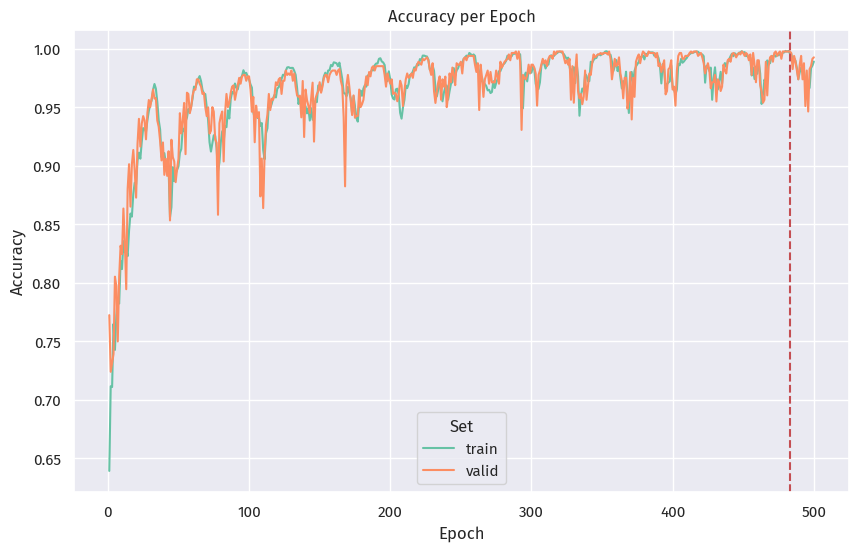

In [17]:
# Acc
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_plot, x='epoch', y='acc', hue='set')
ax.axvline(483, color='r', linestyle='--')

plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Set')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/acc_per_epoch.pdf", bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.show()

In [41]:
ROOT_DIR = os.getcwd()
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoint")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

classes = [enum for enum in ModelNetClass]
classifier = PointnetClassifier(3, 1024, 1024, len(classes)).to(DEVICE)
checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, "best_model.pth"), map_location=torch.device(DEVICE))
classifier.load_state_dict(checkpoint)
classifier = classifier.eval()

In [42]:
test_data = ModelNet(classes, DatasetType.TEST)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=False)

In [48]:
test_labels = list()
test_predictions = list()

with torch.no_grad():
    correct = 0

    for pcds, labels in test_loader:
        pcds = pcds.to(DEVICE)
        labels = labels.squeeze().to(DEVICE)

        out, _, _ = classifier(pcds)
        pred_choice = torch.softmax(out, dim=1).argmax(dim=1)
        correct += pred_choice.eq(labels.data).cpu().sum().item()
        test_labels = test_labels + labels.tolist()
        test_predictions = test_predictions + pred_choice.tolist()




0.920704845814978 0.9189999999999999
0.920704845814978 0.9189999999999999


In [71]:
def class_mapping(n):
    return classes[n].label

test_gt = list(map(class_mapping, test_labels))
test_pred = list(map(class_mapping, test_predictions))

test_oacc = accuracy_score(test_gt, test_pred) * 100
test_macc = balanced_accuracy_score(test_gt, test_pred) * 100
print(test_oacc, test_macc)

92.07048458149781 91.89999999999999


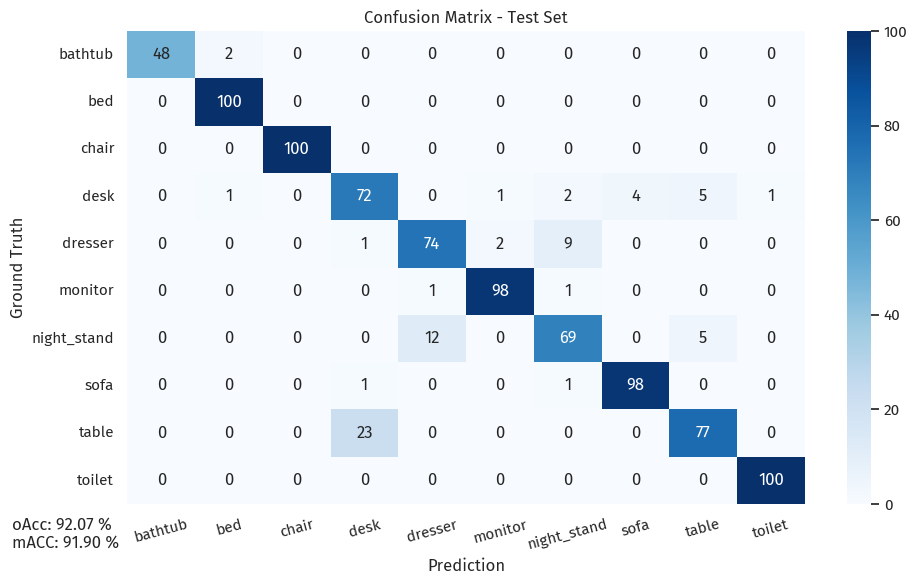

In [76]:
cm = confusion_matrix(test_gt, test_pred, labels=[cls.label for cls in classes])

plt.figure(figsize=(10, 6))
g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[cls.label for cls in classes],
            yticklabels=[cls.label for cls in classes]
)
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
g.set_xticklabels(g.get_yticklabels(), rotation = 15)

plt.title("Confusion Matrix - Test Set")
plt.text(
    -1.7, len(classes) + 1,
    f"oAcc: {test_oacc:.2f} %\nmACC: {test_macc:.2f} %",
    fontsize=12, va='bottom', ha='left'
)
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/test_cm.pdf", bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.show()